Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
SPDX-License-Identifier: Apache-2.0

MILLET Pipeline Example

In [1]:
"""
Initial config
"""
import os

# Navigate to correct directory
print(os.getcwd())
if os.getcwd().endswith("notebooks"):
    os.chdir("../")
print(os.getcwd())

# Setup auto reload of source code changes
%load_ext autoreload
%autoreload 2

D:\Project\MILTimeSeriesClassification\notebooks
D:\Project\MILTimeSeriesClassification


In [2]:
"""
Load WebTraffic dataset
"""
from millet.data.web_traffic_dataset import WebTrafficDataset

train_dataset = WebTrafficDataset("train")
test_dataset = WebTrafficDataset("test")
print("Train Size:", len(train_dataset))
print(" Test Size:", len(test_dataset))

Train Size: 500
 Test Size: 500


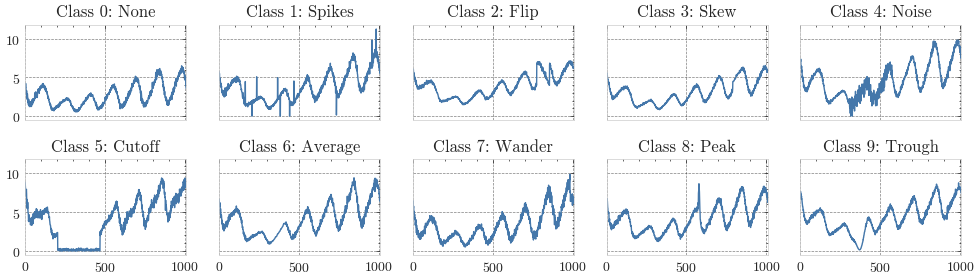

In [3]:
"""
Plot one example per class from WebTraffic
"""
from millet.data.web_traffic_generation import WEBTRAFFIC_CLZ_NAMES
from matplotlib import pyplot as plt

# Need to keep scienceplots imported for matplotlib styling even though the import is never used directly
# noinspection PyUnresolvedReferences
import scienceplots

# Configure matplotlib style
plt.style.use(["science", "bright", "no-latex", "grid"])


def plot_webtraffic_examples(dataset: WebTrafficDataset):
    _, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 3), sharex=True, sharey=True)
    for clz in range(dataset.n_clz):
        # Get a random example for this class
        idx_clz = dataset.get_n_idxs(1, clz=clz, shuffle=True)
        ts = dataset.get_bag(idx_clz)
        # Plot time series
        axis = axes[clz // 5, clz % 5]
        axis.plot(ts)
        axis.set_xlim(0, len(ts))
        axis.set_title("Class {:d}: {:s}".format(clz, WEBTRAFFIC_CLZ_NAMES[clz].capitalize()))


plot_webtraffic_examples(train_dataset)
plt.tight_layout()

In [4]:
"""
Construct a model and train it
"""
from millet.model import backbone
from millet.model import pooling
from millet.model.millet_model import MILLETModel
from millet.util import get_gpu_device_for_os

from torch import nn


# Example network
class ExampleNet(nn.Module):
    def __init__(self, feature_extractor, pool):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.pool = pool

    def forward(self, bags, pos=None):
        timestep_embeddings = self.feature_extractor(bags)
        return self.pool(timestep_embeddings, pos=pos)


# Get GPU enabled device depending on operating system
device = get_gpu_device_for_os()

# Univariate dataset so 1 channel
n_channels = 1

# Pooling config
d_in = 128  # Output size of feature extractor
n_clz = train_dataset.n_clz
dropout = 0.1
apply_positional_encoding = True

# Create network using InceptionTime feature extractor and Conjunctive Pooling
net = ExampleNet(
    # backbone.InceptionTimeFeatureExtractor(n_channels),
    backbone.MultiRocketFeatureExtractor(n_channels),
    pooling.MILConjunctivePooling(
        d_in,
        n_clz,
        dropout=dropout,
        apply_positional_encoding=apply_positional_encoding,
    ),
)

# Create wrapper around net for training, evaluation, etc.
model = MILLETModel("ExampleNet", device, n_clz, net)

# Skip model training (trained weights already provided)
train_model = True
if train_model:
    # model.fit(train_dataset, n_epochs=1500)
    model.fit(train_dataset, n_epochs=1)
    model.save_weights("model/WebTraffic/ExampleNet.pth")
else:
    model.load_weights("model/WebTraffic/ExampleNet.pth")

Training model: 100%|██████████| 1/1 [00:15<00:00, 15.93s/it]
Saving model to model/WebTraffic/ExampleNet.pth


In [5]:
"""
Evaluate model
"""
from texttable import Texttable
import latextable

# Evaluate predictive performance on train and test splits 
train_results_dict = model.evaluate(train_dataset)
test_results_dict = model.evaluate(test_dataset)

# Evaluate interpretability on train and test splits - takes a little while (< 1 min)
train_aopcr, train_ndcg = model.evaluate_interpretability(train_dataset)
test_aopcr, test_ndcg = model.evaluate_interpretability(test_dataset)

header = ["Split", "Accuracy", "AUROC", "Loss", "AOPCR", "NDCG@n"]
train_row = [
    "Train",
    train_results_dict["acc"],
    train_results_dict["auroc"],
    train_results_dict["loss"],
    train_aopcr,
    train_ndcg,
]
test_row = [
    "Test",
    test_results_dict["acc"],
    test_results_dict["auroc"],
    test_results_dict["loss"],
    test_aopcr,
    test_ndcg,
]

results_data = [header, train_row, test_row]

table = Texttable()
table.add_rows(results_data)
table.set_cols_align(["l"] * len(results_data[0]))
table.set_max_width(0)
print("\n-- Results --")
print(table.draw())

print("\n-- Latex Output for Results --")
latex_out = latextable.draw_latex(
    table,
    caption="ExampleNet Results",
    use_booktabs=True,
    label="tab:example_net_results",
)
print(latex_out)

                                               
-- Results --
+-------+----------+-------+-------+-------+--------+
| Split | Accuracy | AUROC | Loss  | AOPCR | NDCG@n |
+=======+==========+=======+=======+=======+========+
| Train | 0.100    | 0.665 | 2.296 | 0.078 | 0.267  |
+-------+----------+-------+-------+-------+--------+
| Test  | 0.102    | 0.643 | 2.297 | 0.078 | 0.267  |
+-------+----------+-------+-------+-------+--------+

-- Latex Output for Results --
\begin{table}
	\begin{center}
		\begin{tabular}{llllll}
			\toprule
			Split & Accuracy & AUROC & Loss & AOPCR & NDCG@n \\
			\midrule
			Train & 0.100 & 0.665 & 2.296 & 0.078 & 0.267 \\
			Test & 0.102 & 0.643 & 2.297 & 0.078 & 0.267 \\
			\bottomrule
		\end{tabular}
	\end{center}
	\caption{ExampleNet Results}
	\label{tab:example_net_results}
\end{table}


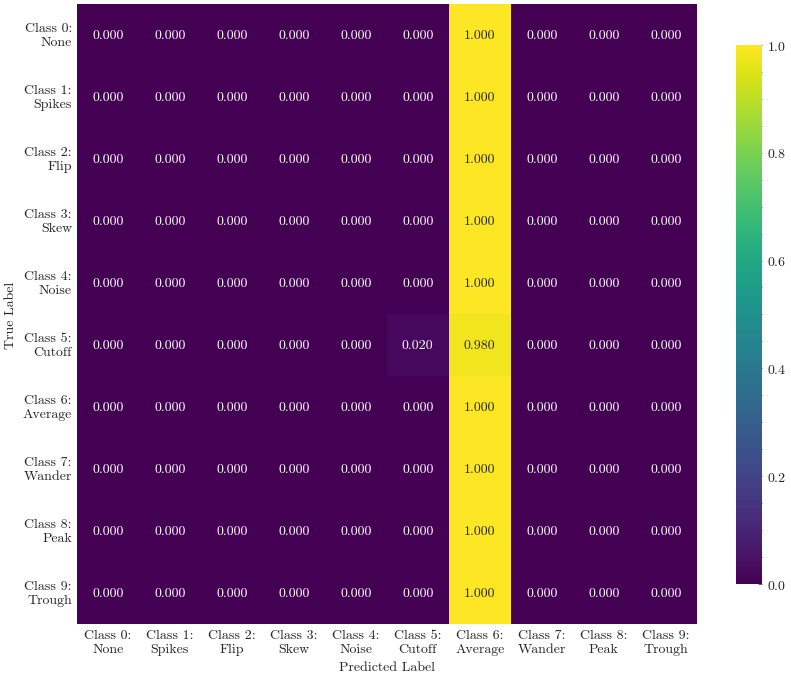

In [6]:
"""
Plot confusion matrix
"""

import seaborn as sns
import torch
from torch.nn.functional import normalize


def plot_conf_mat(conf_mat):
    _, axis = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    norm_conf_mat = normalize(conf_mat, p=1, dim=1)
    sns.heatmap(
        norm_conf_mat,
        ax=axis,
        fmt=".3f",
        cmap="viridis",
        cbar_kws={"shrink": 0.7},
        vmin=0,
        vmax=torch.max(norm_conf_mat),
        annot=True,
    )
    axis.set_aspect("equal")
    axis.tick_params(
        axis="x",
        which="both",
        top=False,
        bottom=False,
        labeltop=False,
        labelbottom=True,
    )
    axis.tick_params(
        axis="y",
        which="both",
        left=False,
        right=False,
        labelleft=True,
        labelright=False,
        labelrotation=0,
    )
    # if clz_names is not None:
    tick_labels = [
        "Class {:d}:\n{:s}".format(idx, clz_name.capitalize()) for idx, clz_name in enumerate(WEBTRAFFIC_CLZ_NAMES)
    ]
    axis.set_xticklabels(tick_labels)
    axis.set_yticklabels(tick_labels)
    axis.set_xlabel("Predicted Label")
    axis.set_ylabel("True Label")


plot_conf_mat(test_results_dict["conf_mat"])

Found 50 time series for class 8 (Peak)
Found 0 peak time series classified as class 0 (None)


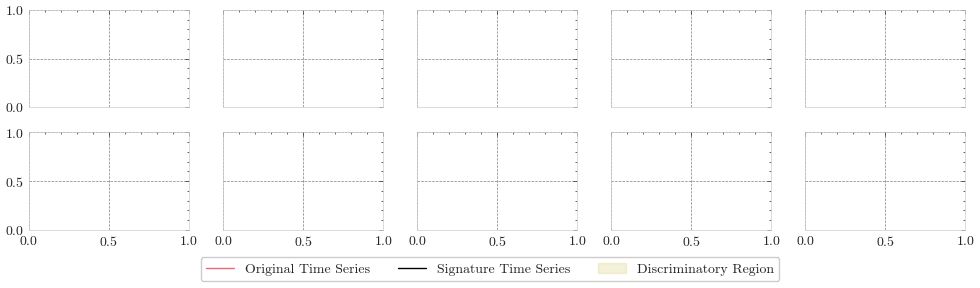

In [7]:
"""
View examples where Peak is classified as None
"""
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

colours = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Get all test time series for Peak class
peak_idxs = [idx.item() for idx in test_dataset.get_clz_idxs(8)]
print("Found {:d} time series for class 8 (Peak)".format(len(peak_idxs)))

peak_as_none_idxs = []
for idx in peak_idxs:
    bag = test_dataset[idx]["bag"]
    model_out = model(bag)
    bag_logits = model_out["bag_logits"]
    pred_clz = torch.argmax(bag_logits).item()
    if pred_clz == 0:
        peak_as_none_idxs.append(idx)

print("Found {:d} peak time series classified as class 0 (None)".format(len(peak_as_none_idxs)))


def plot_misclassified_time_series():
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 3), sharex=True, sharey=True)
    # Plot each "peak as none" example
    for i, idx in enumerate(peak_as_none_idxs):
        # Get original and signature time series
        orig_ts = test_dataset.get_original_time_series(idx)
        sig_ts = test_dataset.get_bag(idx)
        # Plot time series
        axis = axes[i // 5, i % 5]
        axis.plot(orig_ts, color=colours[1])
        axis.plot(sig_ts, color="k")
        # Plot signature location
        signature_locations = test_dataset.get_signature_locations(idx)
        axis.axvspan(*signature_locations[0], alpha=0.4, color=colours[3])
        # Configure axis
        axis.set_xlim(0, len(sig_ts))
        axis.set_title("Idx: {:d}".format(idx))
    # Custom legend
    handles = [
        Line2D([0], [0], color=colours[1]),
        Line2D([0], [0], color="k"),
        Patch(edgecolor=colours[3], facecolor=colours[3], fill=True, alpha=0.2),
    ]
    fig.legend(
        handles=handles,
        labels=[
            "Original Time Series",
            "Signature Time Series",
            "Discriminatory Region",
        ],
        loc="lower center",
        ncol=3,
    )


plot_misclassified_time_series()
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)

-- Idx: 403 --
Class 0 (None): 0.097
Class 8 (Peak): 0.101


C:\Users\giangbv2\AppData\Local\Temp\ipykernel_5056\2044365815.py:41: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[1, i].set_ylim(-int(lim * 1.2), int(lim * 1.2))
C:\Users\giangbv2\AppData\Local\Temp\ipykernel_5056\2044365815.py:42: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes[2, i].set_ylim(-int(lim * 1.2), int(lim * 1.2))


-- Idx: 401 --
Class 0 (None): 0.098
Class 8 (Peak): 0.099
-- Idx: 426 --
Class 0 (None): 0.097
Class 8 (Peak): 0.100


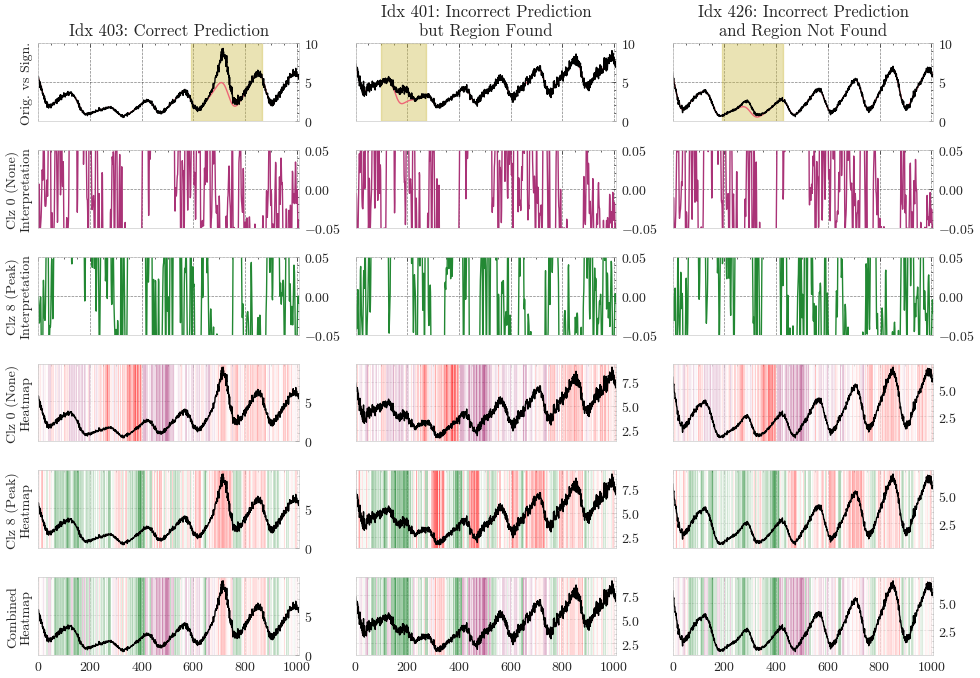

In [8]:
"""
Interpretability study for specific idxs
"""
import matplotlib as mpl


def plot_interpretation_comparison():
    idxs = [403, 401, 426]

    fig, axes = plt.subplots(nrows=6, ncols=3, sharex=True, figsize=(10, 7))

    for i, idx in enumerate(idxs):
        bag = test_dataset[idx]["bag"]
        model_out = model(bag)
        bag_logits = model_out["bag_logits"]
        bag_probas = torch.softmax(bag_logits, dim=0)
        print("-- Idx: {:d} --".format(idx))
        for c in [0, 8]:
            print("Class {:d} ({:s}): {:.3f}".format(c, WEBTRAFFIC_CLZ_NAMES[c].capitalize(), bag_probas[c]))
        clz_interpretations = model.interpret(model_out).detach().cpu()
        none_interpretation = clz_interpretations[0]
        peak_interpretation = clz_interpretations[8]

        lim = max(max(abs(none_interpretation)), max(abs(peak_interpretation)))

        orig_ts = test_dataset.get_original_time_series(idx)
        sig_ts = test_dataset.get_bag(idx)
        # Plot time series
        axes[0, i].plot(orig_ts, color=colours[1])
        axes[0, i].plot(sig_ts, color="k")
        # Plot signature location
        signature_locations = test_dataset.get_signature_locations(idx)
        axes[0, i].axvspan(*signature_locations[0], alpha=0.4, color=colours[3])
        # Configure axis
        axes[0, i].set_xlim(0, len(sig_ts))
        axes[0, i].set_ylim(0, 10)
        # Plot interpretations
        axes[1, i].plot(none_interpretation, color=colours[5])
        axes[2, i].plot(peak_interpretation, color=colours[2])

        axes[1, i].set_ylim(-int(lim * 1.2), int(lim * 1.2))
        axes[2, i].set_ylim(-int(lim * 1.2), int(lim * 1.2))

        norm = plt.Normalize(-lim, lim)
        axes[3, i].plot(sig_ts, color="k")
        plot_single_bg_heatmap(axes[3, i], none_interpretation, get_cmap(colours[5]), norm)

        axes[4, i].plot(sig_ts, color="k")
        plot_single_bg_heatmap(axes[4, i], peak_interpretation, get_cmap(colours[2]), norm)

        axes[5, i].plot(sig_ts, color="k")
        plot_max_bg_heatmap(
            axes[5, i],
            torch.stack([none_interpretation, peak_interpretation]),
            [get_cmap(colours[5]), get_cmap(colours[2])],
            norm,
        )

        for axis in axes[:, i]:
            axis.yaxis.tick_right()

    axes[0, 0].set_title("Idx {:d}: Correct Prediction".format(idxs[0]))
    axes[0, 1].set_title("Idx {:d}: Incorrect Prediction\nbut Region Found".format(idxs[1]))
    axes[0, 2].set_title("Idx {:d}: Incorrect Prediction\nand Region Not Found".format(idxs[2]))

    axes[0, 0].set_ylabel("Orig. vs Sign.")
    axes[1, 0].set_ylabel("Clz 0 (None)\nInterpretation")
    axes[2, 0].set_ylabel("Clz 8 (Peak)\nInterpretation")
    axes[3, 0].set_ylabel("Clz 0 (None)\nHeatmap")
    axes[4, 0].set_ylabel("Clz 8 (Peak)\nHeatmap")
    axes[5, 0].set_ylabel("Combined\nHeatmap")


def plot_single_bg_heatmap(axis, values, cmap, norm, xs=None, alpha=0.8):
    if xs is None:
        xs = range(len(values))
    for x, s in zip(xs, values):
        colour = cmap(norm(s))
        axis.axvspan(x - 0.5, x + 0.5, color=colour, alpha=alpha, lw=0)


def plot_max_bg_heatmap(axis, multi_values, multi_cmap, norm, xs=None, alpha=0.8):
    if xs is None:
        xs = range(multi_values.shape[1])
    maxs = torch.argmax(multi_values, dim=0)
    for x in xs:
        m = maxs[x]
        cmap = multi_cmap[m]
        value = multi_values[m][x]
        colour = cmap(norm(value))
        axis.axvspan(x - 0.5, x + 0.5, color=colour, alpha=alpha, lw=0)


def get_cmap(colour):
    return mpl.colors.LinearSegmentedColormap.from_list("", ["red", "white", colour])


plot_interpretation_comparison()
plt.tight_layout()

In the above diagram, we analyse time series for Class 8 (Peak).

The left column shows a correct example, where the model's prediction is correct and the discriminatory region (the peak) is identified.
The middle column shows an example where the model's prediction is incorrect, but the discriminatory region is still somewhat identifiable from the interpretation.
The right column shows an example where the prediction is incorrect and the discriminatory region is not identified.

The first two sets of heatmaps (rows 4 and 5) visualise the interpretation scores, where scores below zero are in red and scores above zero are in their class colour (purple for class 0 and green for class 8). The strength of the colour indicates the absolute value, i.e. scores near zero are white, and scores far from zero are dark red (refuting) or dark purple/green (supporting).

The final set of heatmaps (row 6) is a combined heatmap across both classes, where the maximal class for each timestep is chosen as the positive colour.